# Minería de Datos: Preprocesamiento y Clasificación - DATCOM - 23/24

## Algoritmo Support Vector Machines (SVM)

Autor: José María López Torres 

### Librerias necesarias

In [1]:
# Importaciones para manejo de datos y dataframes
import numpy as np
from numpy.random import seed
import pandas as pd

# Importaciones para manejo de archivos y llamadas al OS
import os as os
import warnings

# Importaciones para manejo de gráficos
import pylab as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

import optuna # Optimizador de hiperparámetros
from sklearn.feature_selection import SelectKBest, f_classif
from optuna import Trial, create_study
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# No mostrar warnings de versiones anteriores
warnings.filterwarnings('ignore')

In [2]:
# Cargamos csv con los datos de train
df_train = pd.read_csv("../data_raw/training_data.csv", sep=",", header=0, na_values=['?', '', 'NA'])

# Cargamos csv con los datos de test
df_test = pd.read_csv("../data_raw/test_data.csv", sep=",", header=0, na_values=['?', '', 'NA'])

### Análisis Exploratorio de Datos

In [3]:
# Dimensión
print(f"Dimensión del dataset de train:\n {df_train.shape} \n")
print(f"Dimensión del dataset de test:\n {df_test.shape} \n")

# Descripción de las variables
print("Descripción de las variables:\n")
df_train.info()

Dimensión del dataset de train:
 (906, 41) 

Dimensión del dataset de test:
 (389, 40) 

Descripción de las variables:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 906 entries, 0 to 905
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      906 non-null    int64  
 1   X1      906 non-null    int64  
 2   X2      906 non-null    int64  
 3   X3      906 non-null    int64  
 4   X4      649 non-null    float64
 5   X5      906 non-null    int64  
 6   X6      906 non-null    float64
 7   X7      906 non-null    int64  
 8   X8      906 non-null    float64
 9   X9      906 non-null    float64
 10  X10     906 non-null    float64
 11  X11     906 non-null    float64
 12  X12     906 non-null    float64
 13  X13     906 non-null    float64
 14  X14     906 non-null    float64
 15  X15     906 non-null    float64
 16  X16     906 non-null    float64
 17  X17     906 non-null    float64
 18  X18     906 non-null    float6

In [4]:
df_train.describe()

,ID,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X29,X31,X32,X33,X34,X35,X36,X37,X38,X39
count,906.000000,9.060000e+02,9.060000e+02,9.060000e+02,6.490000e+02,9.060000e+02,9.060000e+02,9.060000e+02,9.060000e+02,906.000000,...,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000,906.000000
mean,633.944812,3.448471e+08,1.409140e+08,2.296191e+08,1.679259e+08,3.226934e+08,7.095014e+04,1.834239e+08,2.789998e+06,427.673411,...,1.652058,-2.698231,-0.769670,-6.350003,53.262748,33.762481,19.367833,-6.144963,1.868517,0.042568
std,373.158757,1.011299e+09,4.666272e+08,7.688567e+08,5.322081e+08,9.703791e+08,2.430574e+05,5.380475e+08,1.856681e+07,413.669360,...,3.985377,118.955157,14.969628,49.989149,125.833097,152.764154,15.178570,37.857308,1.920547,0.272180
min,1.000000,4.871587e+06,6.290500e+04,6.277080e+05,1.918500e+04,1.279735e+06,-3.755140e+05,1.158190e+05,4.940000e+02,19.900000,...,0.001800,-1291.330069,-59.883345,-390.835713,-405.450000,-716.824525,-31.590958,-192.898018,0.176400,-2.007800
25%,314.500000,2.871623e+07,5.093032e+06,1.127887e+07,1.434103e+07,2.302948e+07,3.216390e+03,1.071942e+07,9.595350e+04,177.312500,...,0.248725,-8.285000,-3.325000,-5.322500,-1.855000,-19.915000,10.202500,-4.857500,1.019350,-0.033850
50%,617.500000,5.905216e+07,1.601310e+07,2.742359e+07,3.163625e+07,5.728552e+07,1.003438e+04,2.372510e+07,2.280075e+05,297.855000,...,0.754900,0.870000,2.665000,5.410000,33.670000,24.490000,15.855000,3.355000,1.409100,0.064700
75%,956.750000,1.825440e+08,5.803176e+07,9.499336e+07,8.599445e+07,1.707424e+08,3.388975e+04,7.744330e+07,6.547442e+05,511.952500,...,1.752250,5.030000,6.915000,12.762500,83.007500,79.115000,24.372500,8.807500,2.070850,0.155850
max,1295.000000,7.254477e+09,3.540379e+09,5.955596e+09,4.242837e+09,6.869245e+09,2.000147e+06,3.313859e+09,2.679355e+08,2882.360000,...,68.216900,1258.422867,57.725415,244.140000,787.504217,791.913297,69.717079,175.266141,33.602300,3.947700


#### Encoding de variables

Realizamos una codificación de los datos de test y train.

In [10]:
df_train_num = df_train.copy()
df_test_num = df_test.copy()

# 1. "OrdinalEncoder" para X24
orden_x24 = ['VLOW', 'LOW', 'MED', 'HIGH', 'VHIGH']

ordinal_encoder_x24 = OrdinalEncoder(categories=[orden_x24], dtype=int)

df_train_num['X24'] = ordinal_encoder_x24.fit_transform(df_train_num[['X24']])
df_test_num['X24'] = ordinal_encoder_x24.transform(df_test_num[['X24']])

# 2. "OrdinalEncoder" para X25
orden_x25 = ['NO', 'YES']

ordinal_encoder_x25 = OrdinalEncoder(categories=[orden_x25], dtype=int)

df_train_num['X25'] = ordinal_encoder_x25.fit_transform(df_train_num[['X25']])
df_test_num['X25'] = ordinal_encoder_x25.transform(df_test_num[['X25']])

# Si es VTKGN 1 else 0
# Ya que la la clase está muy desbalanceada
df_train_encoded = df_train_num.copy()
df_test_encoded = df_test_num.copy()

df_train_encoded.loc[df_train_num['X30'] == 'VTKGN', 'X30'] = 1
df_train_encoded.loc[df_train_num['X30'] != 'VTKGN', 'X30'] = 0

df_test_encoded.loc[df_test_num['X30'] == 'VTKGN', 'X30'] = 1
df_test_encoded.loc[df_test_num['X30'] != 'VTKGN', 'X30'] = 0

df_train_encoded['X30'] = pd.to_numeric(df_train_encoded['X30'])
df_test_encoded['X30'] = pd.to_numeric(df_train_encoded['X30'])

#### Visualización de las variables

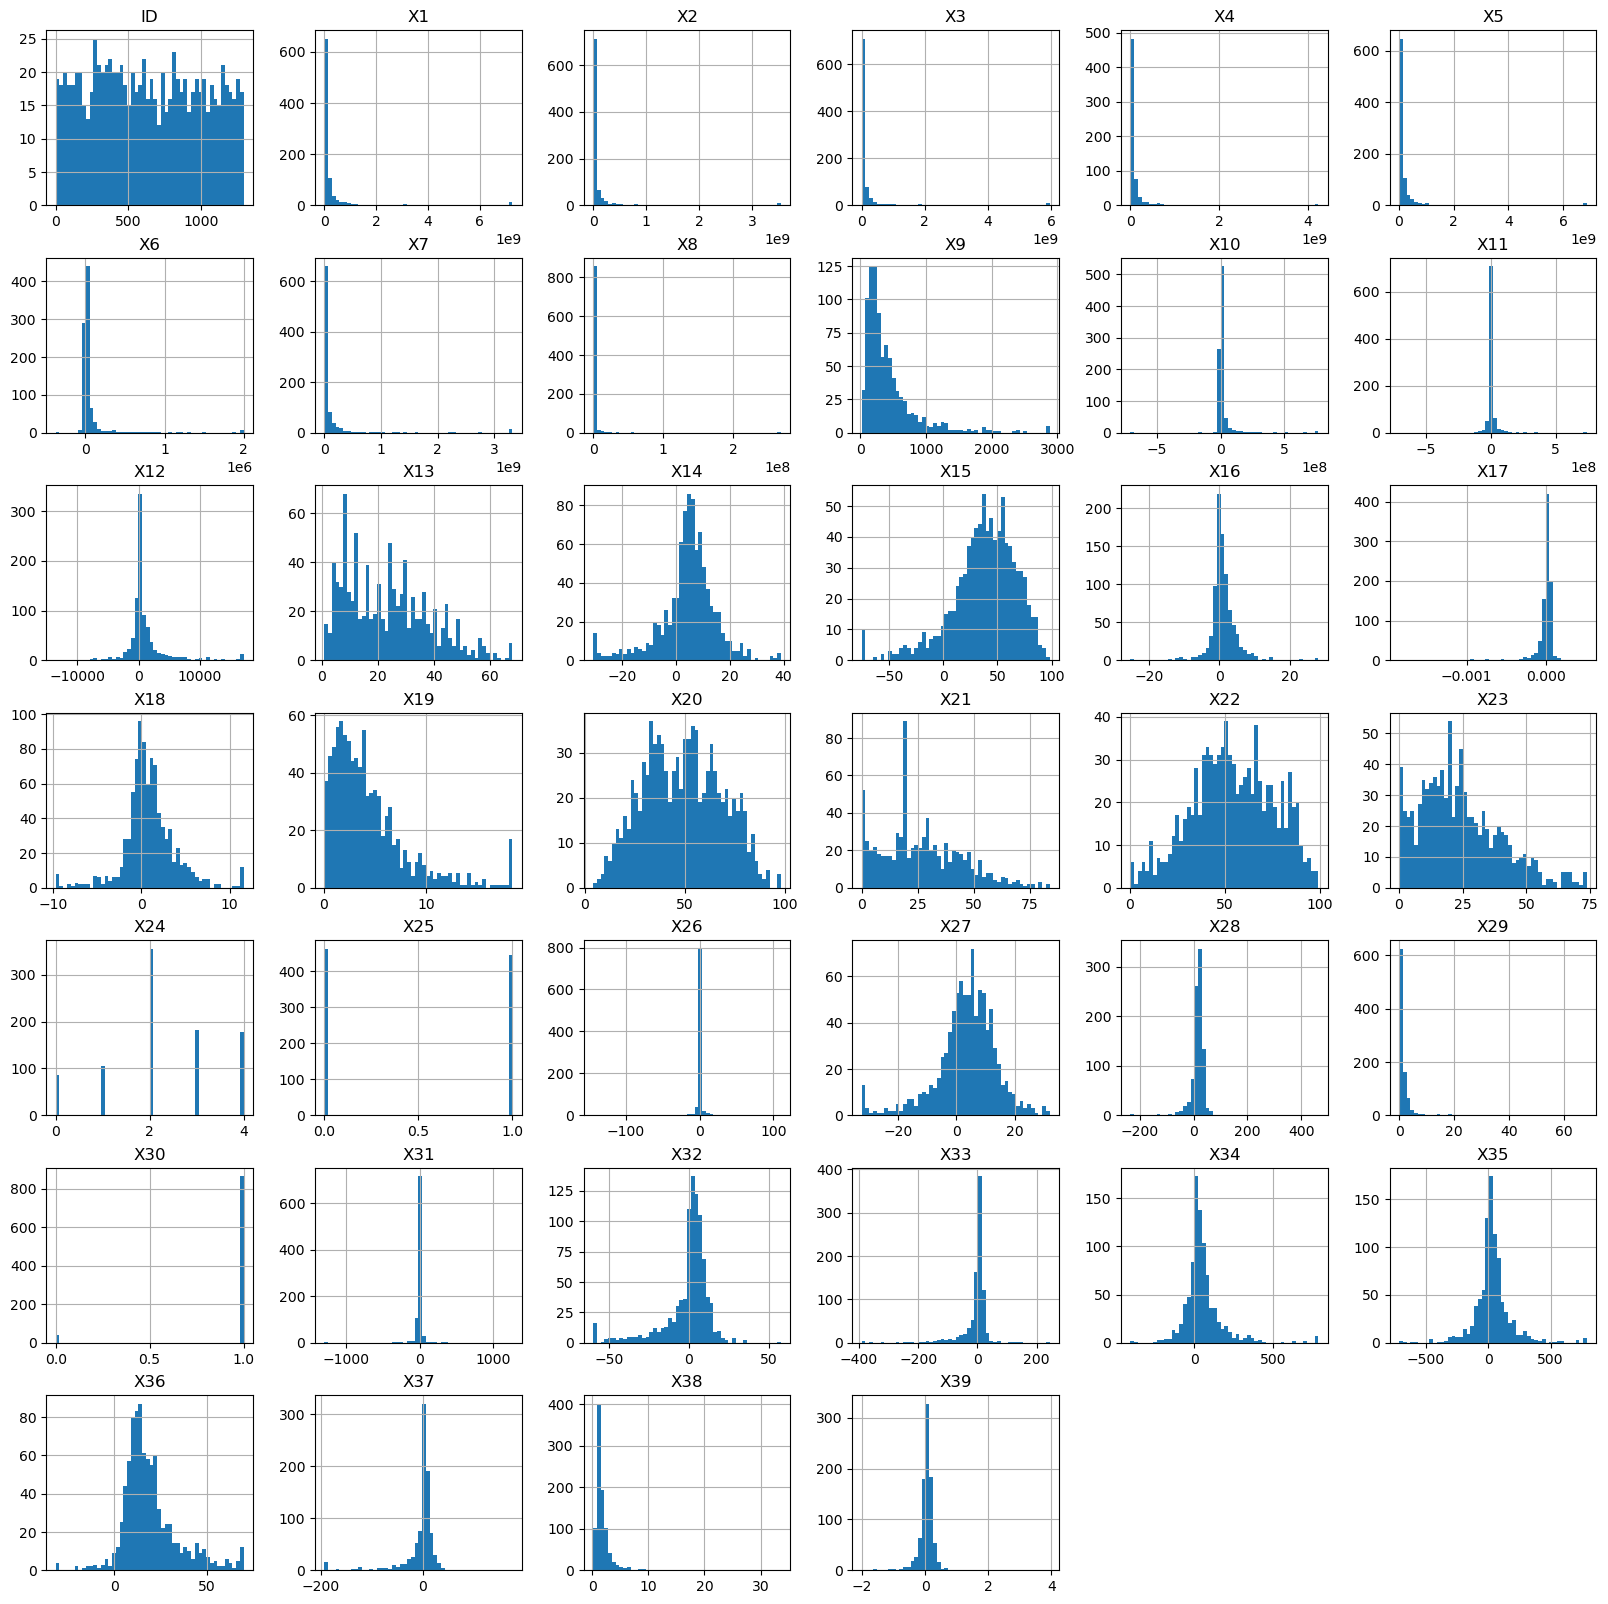

In [11]:
df_train_encoded.hist(figsize = (20,20), bins = 50)
plt.show()

##### Variable Objetivo.

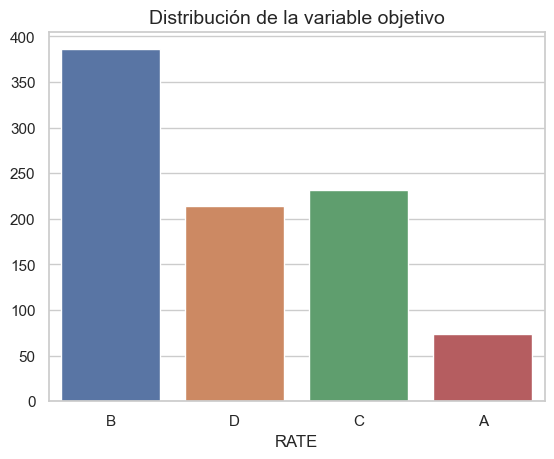

In [12]:
sns.set_theme(style="whitegrid")

sns.countplot(data=df_train_encoded, x="RATE")
plt.title("Distribución de la variable objetivo", fontsize=14)
plt.xlabel("RATE", fontsize=12)
plt.ylabel("", fontsize=12)
plt.show()

##### Variables Categóricas

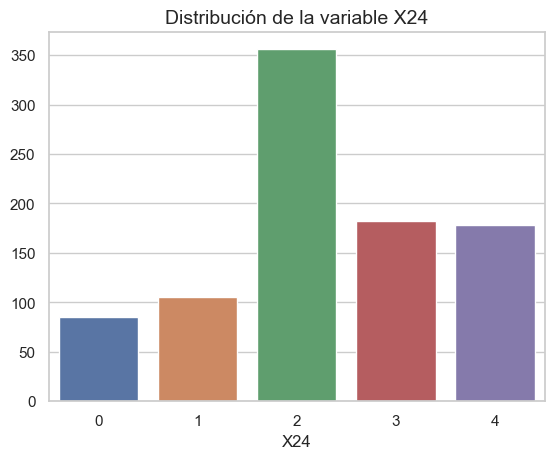

In [13]:
sns.set_theme(style="whitegrid")

sns.countplot(data=df_train_encoded, x="X24")
plt.title("Distribución de la variable X24", fontsize=14)
plt.xlabel("X24", fontsize=12)
plt.ylabel("", fontsize=12)
plt.show()

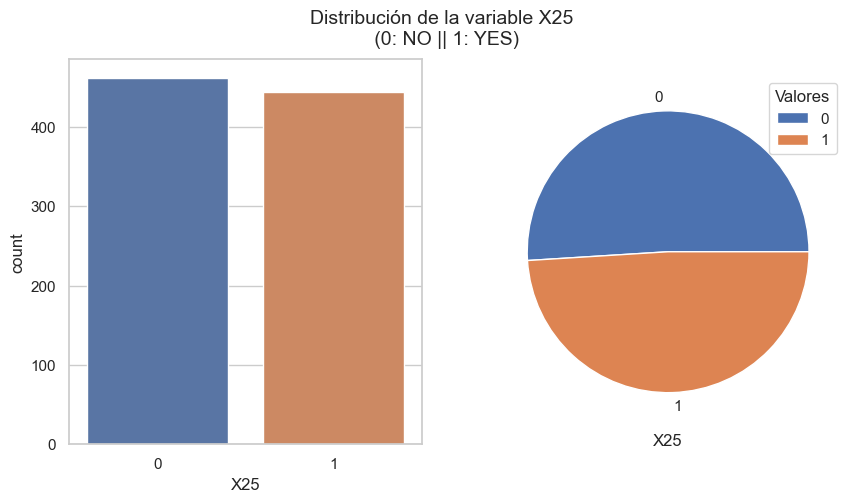

In [14]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

sns.countplot(data=df_train_encoded, x="X25",ax=ax[0])
plt.pie(df_train_encoded["X25"].value_counts(),labels=[0,1])
plt.legend(title="Valores")
plt.suptitle("Distribución de la variable X25 \n (0: NO || 1: YES)", fontsize=14)
# plt.title("Distribución de la variable X25", fontsize=14)
plt.xlabel("X25", fontsize=12)
plt.ylabel("", fontsize=12)
plt.show()

<Axes: xlabel='X25', ylabel='count'>

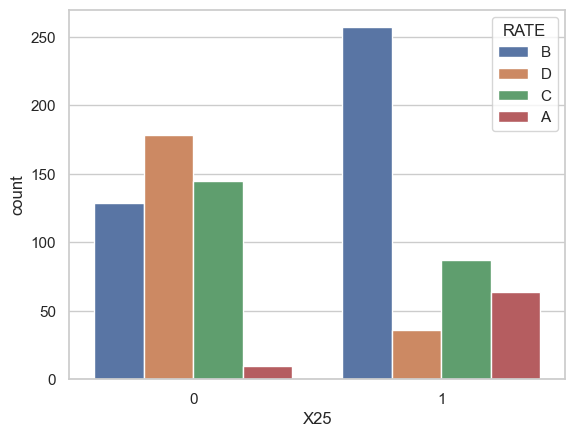

In [15]:
sns.countplot(data=df_train_encoded, x="X25", hue="RATE")

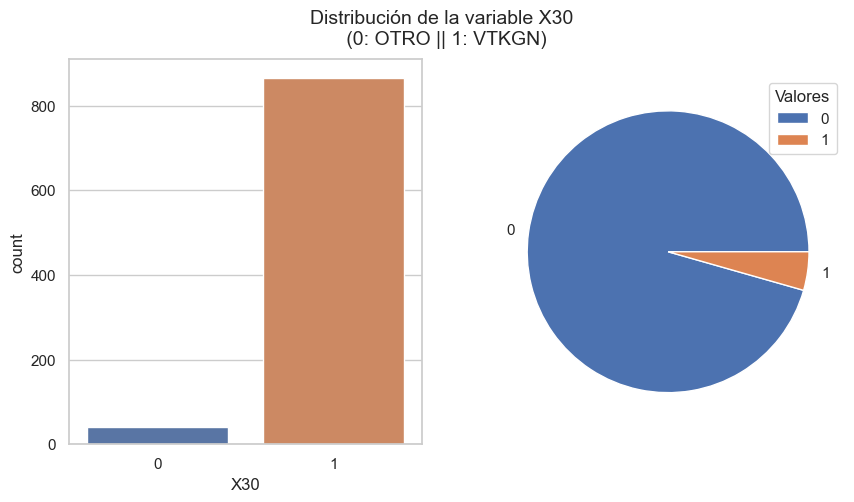

In [16]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

sns.countplot(data=df_train_encoded, x="X30",ax=ax[0])
plt.pie(df_train_encoded["X30"].value_counts(),labels=[0,1])
# sns.countplot(data=df_train_encoded, x="X30", hue="RATE")
plt.legend(title="Valores")
plt.suptitle("Distribución de la variable X30 \n (0: OTRO || 1: VTKGN)", fontsize=14)
# plt.title("Distribución de la variable X30", fontsize=14)
plt.ylabel("", fontsize=12)
plt.show()

<Axes: xlabel='X30', ylabel='count'>

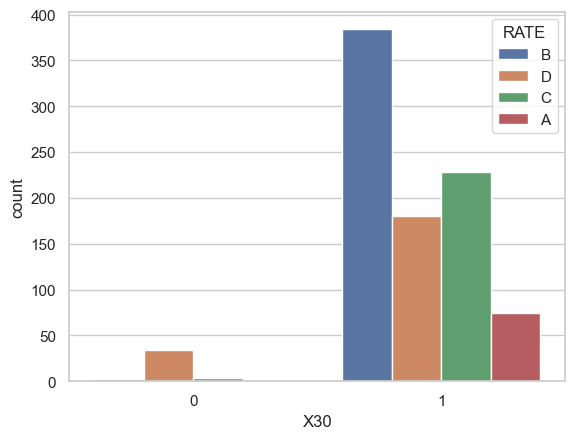

In [17]:
sns.countplot(data=df_train_encoded, x="X30", hue="RATE")

### Funciones de preprocesamiento (imputación, transformación de datos y outliers)

In [18]:
def imp_escala_KNN(n_vecinos, df_train, df_test, escalar=True, tipo_scaler='minmax'):
  
  # Preprocesamiento para TRAIN
  df_final_train = df_train.drop(['ID','RATE'], axis=1, inplace=False)
  train_ID = df_train['ID'].copy()
  train_RATE = df_train['RATE'].copy()
  
  # Preprocesamiento para TEST
  df_final_test = df_test.drop('ID', axis=1, inplace=False)
  test_ID = df_test['ID'].copy()

  if(escalar):
    if(tipo_scaler == 'minmax'):
      scaler = MinMaxScaler()
    elif(tipo_scaler == 'standar'):
      scaler = StandardScaler()
    else:
      scaler = MinMaxScaler()
    
    df_scaled = scaler.fit_transform(df_final_train.to_numpy())
    df_scaled = pd.DataFrame(df_scaled,index=df_final_train.index, columns=[df_final_train.columns])

    df_scaled_test = scaler.transform(df_final_test.to_numpy())
    df_scaled_test = pd.DataFrame(df_scaled_test,index=df_final_test.index, columns=[df_final_test.columns])

  else:
    df_scaled = df_final_train
    df_scaled_test = df_final_test
  
  Knn_imp_train = KNNImputer(n_neighbors=n_vecinos).fit(df_scaled)
  imputed_X_train = pd.DataFrame(Knn_imp_train.transform(df_scaled), columns=df_scaled.columns)

  Knn_imp_test = KNNImputer(n_neighbors=n_vecinos).fit(df_scaled_test)
  imputed_X_test = pd.DataFrame(Knn_imp_test.transform(df_scaled_test), columns=df_scaled_test.columns)

  columns = ['ID']
  columns = np.append(columns, df_final_train.columns)
  columns = np.append(columns, 'RATE')

  result_df_train = pd.merge(train_ID, imputed_X_train, left_index=True, right_index=True)
  result_df_train = pd.merge(result_df_train, train_RATE, left_index=True, right_index=True)
  result_df_train.columns = columns

  columns = ['ID']
  columns = np.append(columns, df_final_test.columns)
  
  result_df_test = pd.merge(test_ID, imputed_X_test, left_index=True, right_index=True)
  result_df_test.columns = columns

  return result_df_train, result_df_test

In [19]:
def imp_escala_Median(df_train, df_test, escalar=True, tipo_scaler='minmax'):
  
  # Preprocesamiento para TRAIN
  df_final_train = df_train.drop(['ID','RATE'], axis=1, inplace=False)
  train_ID = df_train['ID'].copy()
  train_RATE = df_train['RATE'].copy()
  
  # Preprocesamiento para TEST
  df_final_test = df_test.drop('ID', axis=1, inplace=False)
  test_ID = df_test['ID'].copy()

  if(escalar):
    if(tipo_scaler == 'minmax'):
      scaler = MinMaxScaler()
    elif(tipo_scaler == 'standar'):
      scaler = StandardScaler()
    else:
      scaler = MinMaxScaler()
    
    df_scaled = scaler.fit_transform(df_final_train.to_numpy())
    df_scaled = pd.DataFrame(df_scaled, index=df_final_train.index, columns=df_final_train.columns)

    df_scaled_test = scaler.transform(df_final_test.to_numpy())
    df_scaled_test = pd.DataFrame(df_scaled_test, index=df_final_test.index, columns=df_final_test.columns)

  else:
    df_scaled = df_final_train
    df_scaled_test = df_final_test
  
  # Impute missing values using SimpleImputer with median
  imputer = SimpleImputer(strategy='median')
  imputed_X_train = pd.DataFrame(imputer.fit_transform(df_scaled), columns=df_scaled.columns)

  imputed_X_test = pd.DataFrame(imputer.transform(df_scaled_test), columns=df_scaled_test.columns)

  columns = ['ID']
  columns = np.append(columns, df_final_train.columns)
  columns = np.append(columns, 'RATE')

  result_df_train = pd.merge(train_ID, imputed_X_train, left_index=True, right_index=True)
  result_df_train = pd.merge(result_df_train, train_RATE, left_index=True, right_index=True)
  result_df_train.columns = columns

  columns = ['ID']
  columns = np.append(columns, df_final_test.columns)
  
  result_df_test = pd.merge(test_ID, imputed_X_test, left_index=True, right_index=True)
  result_df_test.columns = columns

  return result_df_train, result_df_test

In [20]:
def detect_outliers(df, escalar=True):
  
  # Neceistamos ID, RATE por separado, para escalar y quitar outliers sin que influyan estos parámetros 
  df_train_no_target = df.drop(['ID','RATE'], inplace=False, axis=1).dropna(axis=0, inplace=False)

  if(escalar):
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df_train_no_target.to_numpy())
    df_scaled = pd.DataFrame(df_scaled,index=df_train_no_target.index, columns=[df_train_no_target.columns])
  else:
    df_scaled = df_train_no_target

  lof = LocalOutlierFactor()
  y_pred = lof.fit_predict(df_scaled)
  X_scores = lof.negative_outlier_factor_

  iqr = np.quantile(X_scores, 0.75) - np.quantile(X_scores, 0.25)

  #print("The LOF error score has an IQR of {:.4f}".format(iqr))

  cutoff_value = np.quantile(X_scores, 0.25) - (1.5 * iqr)

  #print("The cutouff value to remove outliers using LOF is {:.4f}".format(cutoff_value))

  # Sacamos los índices de los outliers
  df_outliers = df_scaled[X_scores <= cutoff_value]

  # Quitamos estos índices al df encoded.
  df_result = df.drop(df_outliers.index, axis=0, inplace=False)
  
  return df_result

In [21]:
def preprocesamiento (df_train, df_test):
    
    # Outliers
    isof = IsolationForest(n_estimators = 1000, max_samples = 'auto', contamination = 0.1, n_jobs = -1, random_state = 123)
    df_no_na = df_train.dropna(axis = 0, inplace = False)
    isof.fit(X=df_no_na)
    outliers = isof.predict(X = df_no_na)
    df_no_na['outliers'] = outliers
    indices_outliers = df_no_na.index[df_no_na['outliers'] == -1].tolist()
    df_no_outliers = df_train.drop(index=indices_outliers)

    # Imputar valores faltantes
    imp_train = SimpleImputer(missing_values = np.nan, strategy = 'median').fit(df_no_outliers)
    df_train_imp = pd.DataFrame(imp_train.transform(df_train), columns = df_train.columns, index = df_train.index)

    # Repetir el proceso para el conjunto de prueba
    df_no_na_test = df_test.dropna(axis = 0, inplace=False)
    isof_test = IsolationForest(n_estimators = 1000, max_samples = 'auto', contamination = 0.1, n_jobs = -1, random_state = 123)
    isof_test.fit(X = df_no_na_test)
    outliers_test = isof_test.predict(X = df_no_na_test)
    df_no_na_test['outliers_test'] = outliers_test
    indices_outliers = df_no_na_test.index[df_no_na_test['outliers_test'] == -1].tolist()
    df_no_outliers_test = df_test.drop(index = indices_outliers)

    # Imputar valores faltantes
    imp_test = SimpleImputer(missing_values = np.nan, strategy = 'median').fit(df_no_outliers_test)
    df_test_imp = pd.DataFrame(imp_test.transform(df_test), columns = df_test.columns, index = df_test.index)

    # Escalar los datos
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_train_imp.to_numpy())
    df_scaled = pd.DataFrame(df_scaled, index = df_train_imp.index, columns = df_train_imp.columns)
    df_scaled_test = scaler.transform(df_test_imp.to_numpy())
    df_scaled_test = pd.DataFrame(df_scaled_test, index = df_test_imp.index, columns = df_test_imp.columns)

    return df_scaled, df_scaled_test

### Pruebas de modelos

#### 1ª Prueba

Modelo:
- Sin quitar outliers y con encoder
- Imputando con KNNImputer (n_neighbors = 4)

In [22]:
result_df_train, result_df_test = imp_escala_KNN(4,df_train_encoded, df_test_encoded, True)
y = result_df_train["RATE"]
X = result_df_train.drop(["ID","RATE"],axis=1, inplace=False)

print("Tamaño de los datos de entrenamiento: ", X.shape)
print("Tamaño de las etiquetas de entrenamiento: ", y.shape)

Tamaño de los datos de entrenamiento:  (906, 39)
Tamaño de las etiquetas de entrenamiento:  (906,)


In [25]:
# Dividimos el conjunto de datos en train y test 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Parametros para GridSearch de SVM
param_svc = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [0.1, 1, 10, 100, 1000],
                'kernel': ['rbf', 'sigmoid', 'linear']}

np.random.seed(1234)

SVCM_grid = GridSearchCV(SVC(), param_svc, verbose=1, cv=5, n_jobs=-1, scoring='accuracy')
SVCM_grid.fit(X_train, y_train)

print(SVCM_grid.best_params_)
print(SVCM_grid.best_score_)

y_pred = SVCM_grid.predict(X_test)
print("Informe completo con búsqueda exhaustiva de parámetros\n",classification_report(y_test, y_pred))

Fitting 5 folds for each of 75 candidates, totalling 375 fits
{'C': 10, 'gamma': 0.1, 'kernel': 'linear'}
0.6546551724137931
Informe completo con búsqueda exhaustiva de parámetros
               precision    recall  f1-score   support

           A       0.50      0.36      0.42        14
           B       0.70      0.77      0.73        87
           C       0.49      0.39      0.43        46
           D       0.69      0.77      0.73        35

    accuracy                           0.64       182
   macro avg       0.59      0.57      0.58       182
weighted avg       0.63      0.64      0.63       182



In [26]:
# Dividimos el conjunto de datos en train y test 70/30
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Parametros para GridSearch de SVM
param_svc = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [0.1, 1, 10, 100, 1000],
                'kernel': ['rbf', 'sigmoid', 'linear']}

np.random.seed(1234)

SVCM_grid = GridSearchCV(SVC(), param_svc, verbose=1, cv=5, n_jobs=-1, scoring='accuracy')
SVCM_grid.fit(x_train, y_train)

print(SVCM_grid.best_params_)
print(SVCM_grid.best_score_)

y_pred = SVCM_grid.predict(x_test)
print("Informe completo con búsqueda exhaustiva de parámetros\n",classification_report(y_test, y_pred))

Fitting 5 folds for each of 75 candidates, totalling 375 fits
{'C': 100, 'gamma': 0.1, 'kernel': 'linear'}
0.6293213348331459
Informe completo con búsqueda exhaustiva de parámetros
               precision    recall  f1-score   support

           A       0.37      0.43      0.40        23
           B       0.73      0.68      0.71       130
           C       0.49      0.46      0.48        67
           D       0.67      0.77      0.71        52

    accuracy                           0.62       272
   macro avg       0.56      0.59      0.57       272
weighted avg       0.63      0.62      0.63       272



#### 2ª Prueba

Modelo:

- Imputando con KNN (K = X) y datos escalados (MinMax)

In [27]:
for i in np.arange(1,20):
    result_df_train, result_df_test = imp_escala_KNN(i,df_train_encoded, df_test_encoded, True)
    
    X = result_df_train.drop(['ID','RATE'], inplace=False, axis=1)
    y = result_df_train['RATE']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 32, shuffle=False)

    np.random.seed(1234)
    
    # Parametros para GridSearch de SVM
    param_svc = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [0.1, 1, 10, 100, 1000],
                'kernel': ['rbf', 'sigmoid', 'linear']}
    
    SVCM_grid = GridSearchCV(SVC(), param_svc, verbose=1, cv=5, n_jobs=-1, scoring='accuracy')
    SVCM_grid.fit(X_train, y_train)

    print(f"Intento {i}: Número de vecinos al imputar con KNNImputer: {i}" )
    print(f"Mejores parámetros {SVCM_grid.best_estimator_}")
    print(f"Acc en GridSearch {SVCM_grid.best_score_}")

    y_pred = SVCM_grid.predict(X_test)
    
    print(f"Acc. en Validación: {accuracy_score(y_test, y_pred)}\n\n")
    print("Matriz de confusión:")
    print(confusion_matrix(y_test, y_pred))
    print("Informe completo con búsqueda exhaustiva de parámetros:\n",classification_report(y_test, y_pred))

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Intento 1: Número de vecinos al imputar con KNNImputer: 1
Mejores parámetros SVC(C=10, gamma=0.1)
Acc en GridSearch 0.6481939757530308
Acc. en Validación: 0.6360294117647058


Matriz de confusión:
[[ 3 12  2  0]
 [ 3 96 18  5]
 [ 0 24 23 14]
 [ 0  5 16 51]]
Informe completo con búsqueda exhaustiva de parámetros:
               precision    recall  f1-score   support

           A       0.50      0.18      0.26        17
           B       0.70      0.79      0.74       122
           C       0.39      0.38      0.38        61
           D       0.73      0.71      0.72        72

    accuracy                           0.64       272
   macro avg       0.58      0.51      0.53       272
weighted avg       0.63      0.64      0.62       272

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Intento 2: Número de vecinos al imputar con KNNImputer: 2
Mejores parámetros SVC(C=1000, gamma=0.1, kernel='linear')
Acc en Gr

#### 3ª Prueba

Modelo:
- Imputando con KNN (K = X) y datos escalados (Standar)

In [28]:
for i in np.arange(1,20):
    result_df_train, result_df_test = imp_escala_KNN(i,df_train_encoded, df_test_encoded, True, 'standar')
    
    X = result_df_train.drop(['ID','RATE'], inplace=False, axis=1)
    y = result_df_train['RATE']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 32, shuffle=False)

    np.random.seed(1234)
    
    # Parametros para GridSearch de SVM
    param_svc = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [0.1, 1, 10, 100, 1000],
                'kernel': ['rbf', 'sigmoid', 'linear']}
    
    SVCM_grid = GridSearchCV(SVC(), param_svc, verbose=1, cv=5, n_jobs=-1, scoring='accuracy')
    SVCM_grid.fit(X_train, y_train)

    print(f"Intento {i}: Número de vecinos al imputar con KNNImputer: {i}" )
    print(f"Mejores parámetros {SVCM_grid.best_estimator_}")
    print(f"Acc en GridSearch {SVCM_grid.best_score_}")

    y_pred = SVCM_grid.predict(X_test)
    
    print(f"Acc. en Validación: {accuracy_score(y_test, y_pred)}\n\n")
    print("Matriz de confusión:")
    print(confusion_matrix(y_test, y_pred))
    print("Informe completo con búsqueda exhaustiva de parámetros:\n",classification_report(y_test, y_pred))

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Intento 1: Número de vecinos al imputar con KNNImputer: 1
Mejores parámetros SVC(C=0.1, gamma=0.1, kernel='linear')
Acc en GridSearch 0.6529183852018499
Acc. en Validación: 0.625


Matriz de confusión:
[[ 4 12  1  0]
 [ 5 91 20  6]
 [ 0 24 24 13]
 [ 0  3 18 51]]
Informe completo con búsqueda exhaustiva de parámetros:
               precision    recall  f1-score   support

           A       0.44      0.24      0.31        17
           B       0.70      0.75      0.72       122
           C       0.38      0.39      0.39        61
           D       0.73      0.71      0.72        72

    accuracy                           0.62       272
   macro avg       0.56      0.52      0.53       272
weighted avg       0.62      0.62      0.62       272

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Intento 2: Número de vecinos al imputar con KNNImputer: 2
Mejores parámetros SVC(C=0.1, gamma=0.1, kernel='linear')
Acc e

#### 4ª Prueba

Modelo:
- Imputando con la mediana y datos escalados (MinMax)

In [29]:
result_df_train, result_df_test = imp_escala_Median(df_train_encoded, df_test_encoded, True)
    
X = result_df_train.drop(['ID','RATE'], inplace=False, axis=1)
y = result_df_train['RATE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 32, shuffle=False)

np.random.seed(1234)
    
# Parametros para GridSearch de SVM
param_svc = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [0.1, 1, 10, 100, 1000],
                'kernel': ['rbf', 'sigmoid', 'linear']}
    
SVCM_grid = GridSearchCV(SVC(), param_svc, verbose=1, cv=5, n_jobs=-1, scoring='accuracy')
SVCM_grid.fit(X_train, y_train)

print(f"Mejores parámetros {SVCM_grid.best_estimator_}")
print(f"Acc en GridSearch {SVCM_grid.best_score_}")

y_pred = SVCM_grid.predict(X_test)
    
print(f"Acc. en Validación: {accuracy_score(y_test, y_pred)}\n\n")
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("Informe completo con búsqueda exhaustiva de parámetros:\n",classification_report(y_test, y_pred))

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Mejores parámetros SVC(C=10, gamma=0.1, kernel='linear')
Acc en GridSearch 0.6482189726284214
Acc. en Validación: 0.6360294117647058


Matriz de confusión:
[[ 4 13  0  0]
 [ 4 90 22  6]
 [ 0 22 26 13]
 [ 0  4 15 53]]
Informe completo con búsqueda exhaustiva de parámetros:
               precision    recall  f1-score   support

           A       0.50      0.24      0.32        17
           B       0.70      0.74      0.72       122
           C       0.41      0.43      0.42        61
           D       0.74      0.74      0.74        72

    accuracy                           0.64       272
   macro avg       0.59      0.53      0.55       272
weighted avg       0.63      0.64      0.63       272



#### 5ª Prueba

Modelo:
- Imputando con la mediana y datos escalados (Standardscaler)

In [30]:
result_df_train, result_df_test = imp_escala_Median(df_train_encoded, df_test_encoded, True, 'standar')
    
X = result_df_train.drop(['ID','RATE'], inplace=False, axis=1)
y = result_df_train['RATE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 32, shuffle=False)

np.random.seed(1234)
    
# Parametros para GridSearch de SVM
param_svc = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [0.1, 1, 10, 100, 1000],
                'kernel': ['rbf', 'sigmoid', 'linear']}
    
SVCM_grid = GridSearchCV(SVC(), param_svc, verbose=1, cv=5, n_jobs=-1, scoring='accuracy')
SVCM_grid.fit(X_train, y_train)

print(f"Mejores parámetros {SVCM_grid.best_estimator_}")
print(f"Acc en GridSearch {SVCM_grid.best_score_}")

y_pred = SVCM_grid.predict(X_test)
    
print(f"Acc. en Validación: {accuracy_score(y_test, y_pred)}\n\n")
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("Informe completo con búsqueda exhaustiva de parámetros:\n",classification_report(y_test, y_pred))

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Mejores parámetros SVC(C=100, gamma=0.1, kernel='linear')
Acc en GridSearch 0.6498062742157231
Acc. en Validación: 0.6360294117647058


Matriz de confusión:
[[11  6  0  0]
 [ 8 84 24  6]
 [ 1 20 28 12]
 [ 0  4 18 50]]
Informe completo con búsqueda exhaustiva de parámetros:
               precision    recall  f1-score   support

           A       0.55      0.65      0.59        17
           B       0.74      0.69      0.71       122
           C       0.40      0.46      0.43        61
           D       0.74      0.69      0.71        72

    accuracy                           0.64       272
   macro avg       0.61      0.62      0.61       272
weighted avg       0.65      0.64      0.64       272



#### 6ª Prueba

Modelo:

- Quitando outliers
- Imputando con KNN (K = X) y datos escalados (MinMax)

In [31]:
for i in np.arange(1,20):
    df_sin_outliers = detect_outliers(df_train_encoded, True)
    result_df_train, result_df_test = imp_escala_KNN(i,df_sin_outliers, df_test_encoded, True)
    
    X = result_df_train.drop(['ID','RATE'], inplace=False, axis=1)
    y = result_df_train['RATE']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 32, shuffle=False)

    np.random.seed(1234)
    
    # Parametros para GridSearch de SVM
    param_svc = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [0.1, 1, 10, 100, 1000],
                'kernel': ['rbf', 'sigmoid', 'linear']}
    
    SVCM_grid = GridSearchCV(SVC(), param_svc, verbose=1, cv=5, n_jobs=-1, scoring='accuracy')
    SVCM_grid.fit(X_train, y_train)

    print(f"Intento {i}: Número de vecinos al imputar con KNNImputer: {i}" )
    print(f"Mejores parámetros {SVCM_grid.best_estimator_}")
    print(f"Acc en GridSearch {SVCM_grid.best_score_}")

    y_pred = SVCM_grid.predict(X_test)
    
    print(f"Acc. en Validación: {accuracy_score(y_test, y_pred)}\n\n")
    print("Matriz de confusión:")
    print(confusion_matrix(y_test, y_pred))
    print("Informe completo con búsqueda exhaustiva de parámetros:\n",classification_report(y_test, y_pred))
    

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Intento 1: Número de vecinos al imputar con KNNImputer: 1
Mejores parámetros SVC(C=0.1, gamma=0.1)
Acc en GridSearch 0.4144257703081232
Acc. en Validación: 0.4453125


Matriz de confusión:
[[  0  13   0   0]
 [  0 114   0   0]
 [  0  59   0   0]
 [  0  70   0   0]]
Informe completo con búsqueda exhaustiva de parámetros:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00        13
           B       0.45      1.00      0.62       114
           C       0.00      0.00      0.00        59
           D       0.00      0.00      0.00        70

    accuracy                           0.45       256
   macro avg       0.11      0.25      0.15       256
weighted avg       0.20      0.45      0.27       256

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Intento 2: Número de vecinos al imputar con KNNImputer: 2
Mejores parámetros SVC(C=0.1, gamma=0.1)
Acc en GridSearch 0

#### 7ª Prueba

Modelo:

- Quitando outliers
- Imputando con la mediana y datos escalados (MinMax)

In [32]:
df_sin_outliers = detect_outliers(df_train_encoded, True)
result_df_train, result_df_test = imp_escala_Median(df_sin_outliers, df_test_encoded, True)
    
X = result_df_train.drop(['ID','RATE'], inplace=False, axis=1)
y = result_df_train['RATE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 32, shuffle=False)

np.random.seed(1234)
    
# Parametros para GridSearch de SVM
param_svc = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [0.1, 1, 10, 100, 1000],
                'kernel': ['rbf', 'sigmoid', 'linear']}
    
SVCM_grid = GridSearchCV(SVC(), param_svc, verbose=1, cv=5, n_jobs=-1, scoring='accuracy')
SVCM_grid.fit(X_train, y_train)

print(f"Mejores parámetros {SVCM_grid.best_estimator_}")
print(f"Acc en GridSearch {SVCM_grid.best_score_}")

y_pred = SVCM_grid.predict(X_test)
    
print(f"Acc. en Validación: {accuracy_score(y_test, y_pred)}\n\n")
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("Informe completo con búsqueda exhaustiva de parámetros:\n",classification_report(y_test, y_pred))

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Mejores parámetros SVC(C=0.1, gamma=0.1)
Acc en GridSearch 0.4144257703081232
Acc. en Validación: 0.4453125


Matriz de confusión:
[[  0  13   0   0]
 [  0 114   0   0]
 [  0  59   0   0]
 [  0  70   0   0]]
Informe completo con búsqueda exhaustiva de parámetros:
               precision    recall  f1-score   support

           A       0.00      0.00      0.00        13
           B       0.45      1.00      0.62       114
           C       0.00      0.00      0.00        59
           D       0.00      0.00      0.00        70

    accuracy                           0.45       256
   macro avg       0.11      0.25      0.15       256
weighted avg       0.20      0.45      0.27       256



#### 8ª Prueba

Modelo:

- Sin quitar outliers
- Imputando con KNN (K = X) y datos escalados (MinMax)
- Aplicamos Over sampling, SMOTE

In [33]:
print(df_train_encoded.groupby(['RATE'])['RATE'].count())
print("\n")
print(df_train_encoded.shape)

RATE
A     74
B    386
C    232
D    214
Name: RATE, dtype: int64


(906, 41)


RATE
A     74
B    386
C    232
D    214
Name: RATE, dtype: int64


(906, 41)


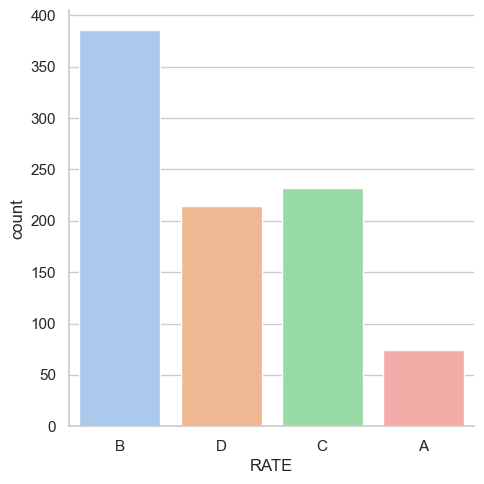

In [34]:
#1. Imputamos con k=5 y escalamos
result_df_train, result_df_test = imp_escala_KNN(5,df_train_encoded,df_test_encoded,True)

sns.catplot(data=result_df_train, x="RATE", kind="count", palette="pastel")

print(result_df_train.groupby(['RATE'])['RATE'].count())
print("\n")
print(result_df_train.shape)

In [35]:
for i in np.arange(1,20):
    
    result_df_train, result_df_test = imp_escala_KNN(i,df_train_encoded, df_test_encoded, True)
    
    X = result_df_train.drop(['ID','RATE'], inplace=False, axis=1)
    y = result_df_train['RATE']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state = 32, shuffle=True)
    X_train_resampled, y_train_resampled = SMOTE(random_state=42).fit_resample(X_train, y_train)

    np.random.seed(1234)

    # Parametros para GridSearch de SVM
    param_svc = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [0.1, 1, 10, 100, 1000],
                'kernel': ['rbf', 'sigmoid', 'linear']}
    
    SVCM_grid = GridSearchCV(SVC(), param_svc, verbose=1, cv=5, n_jobs=-1, scoring='accuracy')
    SVCM_grid.fit(X_train_resampled, y_train_resampled)

    print(f"Intento {i}: Número de vecinos al imputar con KNNImputer: {i}" )
    print(f"Mejores parámetros {SVCM_grid.best_estimator_}")
    print(f"Acc en GridSearch {SVCM_grid.best_score_}")

    y_pred = SVCM_grid.predict(X_test)
  
    print(f"Acc. en Validación: {accuracy_score(y_test, y_pred)}\n")
    print(f"Matriz de confusión:\n {confusion_matrix(y_test, y_pred)}\n\n")
    # print(confusion_matrix(y_test, y_pred)"\n\n")
    print("Informe completo con búsqueda exhaustiva de parámetros:\n",classification_report(y_test, y_pred))

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Intento 1: Número de vecinos al imputar con KNNImputer: 1
Mejores parámetros SVC(C=10, gamma=10)
Acc en GridSearch 0.8193654524089306
Acc. en Validación: 0.4931129476584022

Matriz de confusión:
 [[  3  28   0   1]
 [  2 130  18   5]
 [  0  53  14  19]
 [  0  41  17  32]]


Informe completo con búsqueda exhaustiva de parámetros:
               precision    recall  f1-score   support

           A       0.60      0.09      0.16        32
           B       0.52      0.84      0.64       155
           C       0.29      0.16      0.21        86
           D       0.56      0.36      0.44        90

    accuracy                           0.49       363
   macro avg       0.49      0.36      0.36       363
weighted avg       0.48      0.49      0.44       363

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Intento 2: Número de vecinos al imputar con KNNImputer: 2
Mejores parámetros SVC(C=10, gamma=10)
Acc en GridS

#### 9ª Prueba 

Modelo:
- Sin quitar outliers
- Imputando con la mediana y datos escalados (MinMax)
- Aplicamos Over sampling, SMOTE

In [36]:
result_df_train, result_df_test = imp_escala_Median(df_train_encoded, df_test_encoded, True)
    
X = result_df_train.drop(['ID','RATE'], inplace=False, axis=1)
y = result_df_train['RATE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 32, shuffle=False)
X_train_resampled, y_train_resampled = SMOTE(random_state=42).fit_resample(X_train, y_train)

np.random.seed(1234)

# Parametros para GridSearch de SVM
param_svc = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [0.1, 1, 10, 100, 1000],
                'kernel': ['rbf', 'sigmoid', 'linear']}
    
SVCM_grid = GridSearchCV(SVC(), param_svc, verbose=1, cv=5, n_jobs=-1, scoring='accuracy')
SVCM_grid.fit(X_train_resampled, y_train_resampled)

print(f"Mejores parámetros {SVCM_grid.best_estimator_}")
print(f"Acc en GridSearch {SVCM_grid.best_score_}")

y_pred = SVCM_grid.predict(X_test)
  
print(f"Acc. en Validación: {accuracy_score(y_test, y_pred)}\n")
print(f"Matriz de confusión:\n {confusion_matrix(y_test, y_pred)}\n\n")
# print(confusion_matrix(y_test, y_pred)"\n\n")
print("Informe completo con búsqueda exhaustiva de parámetros:\n",classification_report(y_test, y_pred))

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Mejores parámetros SVC(C=100, gamma=1)
Acc en GridSearch 0.833385495841903
Acc. en Validación: 0.5661764705882353

Matriz de confusión:
 [[12  3  2  0]
 [12 71 32  7]
 [ 0 25 27  9]
 [ 0  9 19 44]]


Informe completo con búsqueda exhaustiva de parámetros:
               precision    recall  f1-score   support

           A       0.50      0.71      0.59        17
           B       0.66      0.58      0.62       122
           C       0.34      0.44      0.38        61
           D       0.73      0.61      0.67        72

    accuracy                           0.57       272
   macro avg       0.56      0.59      0.56       272
weighted avg       0.60      0.57      0.58       272



#### 10ª prueba

Modelo:
- Sin quitar outliers
- Imputando con la mediana y datos escalados (MinMax)
- Aplicando Over sampling, SMOTE
- OVO y OVA

In [37]:
from sklearn.multiclass import OneVsOneClassifier

X = result_df_train.drop(['ID','RATE'], inplace=False, axis=1)
y = result_df_train['RATE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 32, shuffle=False)
X_train_resampled, y_train_resampled = SMOTE(random_state=42).fit_resample(X_train, y_train)

np.random.seed(1234)

# Parametros para GridSearch de SVM
param_svc = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [0.1, 1, 10, 100, 1000],
                'kernel': ['rbf', 'sigmoid', 'linear']}
    
SVCM_grid = GridSearchCV(SVC(), param_svc, verbose=1, cv=5, n_jobs=-1, scoring='accuracy')
ovo = OneVsOneClassifier(SVCM_grid)
ovo.fit(X_train_resampled, y_train_resampled)

y_pred = ovo.predict(X_test)
print("Informe completo para OVO wrapper\n",classification_report(y_test, y_pred))

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Informe completo para OVO wrapper
               precision    recall  f1-score   support

           A       0.50      0.12      0.19        17
           B       0.70      0.66      0.68       122
           C       0.36      0.52      0.43        61
           D       0.69      0.61      0.65        72

    accuracy                           0.58       272
   macro avg       0.56      0.48      0.48       272
weighted avg       0.61      0.58      0.58       272



In [38]:
from sklearn.multiclass import OneVsRestClassifier

X = result_df_train.drop(['ID','RATE'], inplace=False, axis=1)
y = result_df_train['RATE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 32, shuffle=False)
X_train_resampled, y_train_resampled = SMOTE(random_state=42).fit_resample(X_train, y_train)

np.random.seed(1234)

# Parametros para GridSearch de SVM
param_svc = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [0.1, 1, 10, 100, 1000],
                'kernel': ['rbf', 'sigmoid', 'linear']}
    
SVCM_grid = GridSearchCV(SVC(), param_svc, verbose=1, cv=5, n_jobs=-1, scoring='accuracy')
ova = OneVsRestClassifier(SVCM_grid)
ova.fit(X_train_resampled, y_train_resampled)

y_pred = ova.predict(X_test)
print("Informe completo para OVA wrapper\n",classification_report(y_test, y_pred))

Fitting 5 folds for each of 75 candidates, totalling 375 fits
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Fitting 5 folds for each of 75 candidates, totalling 375 fits
Informe completo para OVA wrapper
               precision    recall  f1-score   support

           A       0.50      0.29      0.37        17
           B       0.65      0.69      0.67       122
           C       0.32      0.36      0.34        61
           D       0.71      0.62      0.67        72

    accuracy                           0.57       272
   macro avg       0.54      0.49      0.51       272
weighted avg       0.58      0.57      0.57       272



##### Resultados para Kaggle

In [ ]:
X_final = result_df_test.drop('ID', axis=1, inplace=False)
test_ID = result_df_test['ID'].copy()

y_pred = ovo.predict(X_final)
y_pred_df = pd.DataFrame({'ID':test_ID,'TARGET':y_pred})

y_pred_df.to_csv('../Resultados/prediccion.csv', index=False, sep=',')

#### 11ª prueba

Modelo:
- Aplicando nuevas técnicas de preprocesamiento
- Sin quitar outliers
- Aplicando la raíz cuadrada a las variables que se dispersan
- Imputando con la medina y escalando con StandardScaler

##### Preprocesamiento

In [39]:
np.random.seed(1234)

df_train = df_train_encoded
df_test = df_test_encoded

# Preprocesamiento para TRAIN
df_final_train = df_train.drop(['ID','RATE'], axis=1, inplace=False)
train_ID = df_train['ID'].copy()
train_RATE = df_train['RATE'].copy()

# Preprocesamiento para TEST
df_final_test = df_test.drop('ID', axis=1, inplace=False)
test_ID = df_test['ID'].copy()

<Axes: xlabel='column', ylabel='value'>

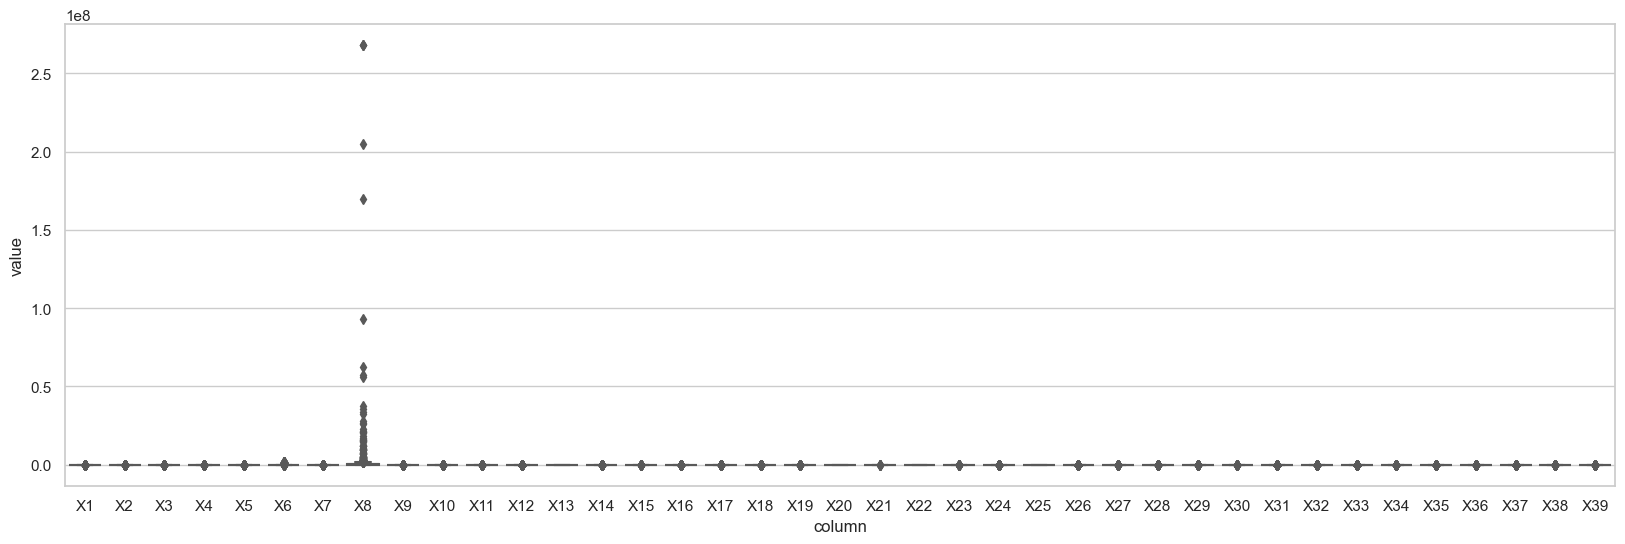

In [40]:
df_train_copy = df_final_train.copy()
df_test_copy = df_final_test.copy()

# Escala raíz cuadrada a las que se dispersan mucho
df_train_copy[['X1','X2','X3','X4','X5','X7','X10','X11']] = np.sqrt(df_train_copy[['X1','X2','X3','X4','X5','X7','X10','X11']])
df_test_copy[['X1','X2','X3','X4','X5','X7','X10','X11']] = np.sqrt(df_test_copy[['X1','X2','X3','X4','X5','X7','X10','X11']])

# Escala logarítmica a las que se dispersan mucho
# df_train_copy[['X1','X2','X3','X4','X5','X7','X10','X11']] = np.log(df_train_copy[['X1','X2','X3','X4','X5','X7','X10','X11']])
# df_test_copy[['X1','X2','X3','X4','X5','X7','X10','X11']] = np.log(df_test_copy[['X1','X2','X3','X4','X5','X7','X10','X11']])

df_melted = df_train_copy.melt(var_name='column')

plt.figure(figsize=(20,6))
sns.boxplot(data=df_melted, color="#3BA3EC", x="column", y="value")

In [41]:
df_train_scaled, df_test_scaled = preprocesamiento(df_train_copy, df_test_copy)

# Componemos las columnas
columns = ['ID']
columns = np.append(columns, df_train_copy.columns)
columns = np.append(columns, 'RATE')

result_df_train = pd.merge(train_ID, df_train_scaled, left_index=True, right_index=True)
result_df_train = pd.merge(result_df_train, train_RATE, left_index=True, right_index=True)
result_df_train.columns = columns

columns = ['ID']
columns = np.append(columns, df_test_copy.columns)

result_df_test = pd.merge(test_ID, df_test_scaled, left_index=True, right_index=True)
result_df_test.columns = columns

In [42]:
X = result_df_train.drop(['ID','RATE'], inplace=False, axis=1)
y = result_df_train['RATE']

# Dividimos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 32, shuffle=True)

# Aplicamos el algoritmo
param_svc = {'C': [0.1, 1, 10, 100, 1000, 10000], 
             'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
             'kernel': ['rbf', 'poly', 'sigmoid', 'linear'],
             'class_weight': ['balanced', None]
             }

SVCM_grid = GridSearchCV(SVC(), param_svc, verbose=1, cv=5, n_jobs=-1, scoring='accuracy')
SVCM_grid.fit(X_train, y_train)

print(f"Mejores parámetros {SVCM_grid.best_estimator_}")
print(f"Acc en GridSearch {SVCM_grid.best_score_}")

y_pred = SVCM_grid.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Acc. en Validación: {acc}\n")

print("Informe completo con búsqueda exhaustiva de parámetros:\n",classification_report(y_test, y_pred))

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Mejores parámetros SVC(C=10000, gamma=0.0001)
Acc en GridSearch 0.6650306748466258
Acc. en Validación: 0.6043956043956044

Informe completo con búsqueda exhaustiva de parámetros:
               precision    recall  f1-score   support

           A       0.50      0.43      0.46         7
           B       0.61      0.87      0.72        31
           C       0.58      0.41      0.48        27
           D       0.64      0.54      0.58        26

    accuracy                           0.60        91
   macro avg       0.58      0.56      0.56        91
weighted avg       0.60      0.60      0.59        91



In [ ]:
X_final = result_df_test.drop('ID', axis=1, inplace=False)
test_ID = result_df_test['ID'].copy()

y_pred = SVCM_grid.predict(X_final)
df_pred = pd.DataFrame({'ID':test_ID,'TARGET':y_pred})

df_pred.to_csv('../Resultados/prediccion.csv', index=False, sep=',')

#### 12ª prueba

Modelo:
- Aplicando nuevas técnicas de preprocesamiento
- Sin quitar outliers
- Aplicando la raíz cuadrada a las variables que se dispersan
- Imputando con la mediana y escalando con StandardScaler
- Aplicación de Optuna para encontrar los mejores hiperpárametros

In [43]:
X = result_df_train.drop(['ID','RATE'], inplace=False, axis=1)
y = result_df_train['RATE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define la función objetivo
def objective(trial):
    
    # Define el espacio de búsqueda de hiperparámetros
    C = trial.suggest_loguniform('C', 0.001, 10000)
    gamma = trial.suggest_loguniform('gamma', 0.001, 10000)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    degree = trial.suggest_int('degree', 1, 10)
    shrinking = trial.suggest_categorical('shrinking', [True, False])
    coef0 = trial.suggest_uniform('coef0', 0.0, 10.0)
    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])

    # Crea y entrena el modelo SVM
    classifier_obj = svm.SVC(C=C, gamma=gamma, kernel=kernel, degree=degree, shrinking=shrinking, coef0=coef0, class_weight=class_weight)
    classifier_obj.fit(X_train, y_train)

    # Evalúa el modelo
    y_pred = classifier_obj.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

In [ ]:
# Crea el estudio y optimiza
study = optuna.create_study(direction = 'maximize', sampler = optuna.samplers.TPESampler(seed=1234))
study.optimize(objective, n_trials = 10, show_progress_bar = True)

# Imprime los mejores hiperparámetros
print('Best trial:')
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Imprime el informe de clasificación del mejor ensayo
best_trial = study.best_trial
best_classifier = SVC(**best_trial.params)
best_classifier.fit(X_train, y_train)
y_pred = best_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

[I 2024-01-19 15:41:27,826] A new study created in memory with name: no-name-373c75ba-e77b-49d3-ac1f-d1a293b4bd2b


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2024-01-19 15:41:27,866] Trial 0 finished with value: 0.5808823529411765 and parameters: {'C': 0.02190968595786366, 'gamma': 22.634004467821956, 'kernel': 'poly', 'degree': 3, 'shrinking': False, 'coef0': 8.759326347420947, 'class_weight': None}. Best is trial 0 with value: 0.5808823529411765.
[I 2024-01-19 15:41:27,942] Trial 1 finished with value: 0.47794117647058826 and parameters: {'C': 60.847192724058154, 'gamma': 97.47970110758654, 'kernel': 'poly', 'degree': 8, 'shrinking': True, 'coef0': 6.153961784334937, 'class_weight': None}. Best is trial 0 with value: 0.5808823529411765.
[I 2024-01-19 15:41:27,980] Trial 2 finished with value: 0.5257352941176471 and parameters: {'C': 3403.9307321092724, 'gamma': 36.27830624390474, 'kernel': 'poly', 'degree': 9, 'shrinking': False, 'coef0': 1.4376682451456457, 'class_weight': None}. Best is trial 0 with value: 0.5808823529411765.
[I 2024-01-19 15:41:29,798] Trial 3 finished with value: 0.6727941176470589 and parameters: {'C': 0.034005153

In [ ]:
X_final = result_df_test.drop('ID', axis=1, inplace=False)
test_ID = result_df_test['ID'].copy()

y_pred = best_classifier.predict(X_final)
df_pred = pd.DataFrame({'ID':test_ID,'TARGET':y_pred})

df_pred.to_csv('../Resultados/prediccion_optuna.csv', index=False, sep=',')

ValueError: Found input variables with inconsistent numbers of samples: [272, 389]

#### 13ª prueba

Modelo:
- Sin quitar outliers
- Aplicando la raíz cuadrada a las variables que se dispersan
- Imputando con la mediana y escalando con StandardScaler
- Aplicación de Optuna para encontrar los mejores hiperpárametros
- Validación Cruzada Estratificada

In [ ]:
X = result_df_train.drop(['ID','RATE'], inplace=False, axis=1)
y = result_df_train['RATE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define la función objetivo
def objective(trial):
    
    # Define el espacio de búsqueda de hiperparámetros
    C = trial.suggest_loguniform('C', 0.001, 10000)
    gamma = trial.suggest_loguniform('gamma', 0.001, 10000)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    degree = trial.suggest_int('degree', 1, 10)
    shrinking = trial.suggest_categorical('shrinking', [True, False])
    coef0 = trial.suggest_uniform('coef0', 0.0, 10.0)
    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])

    # Crea el modelo SVM
    classifier_obj = SVC(C=C, gamma=gamma, kernel=kernel, degree=degree, shrinking=shrinking, coef0=coef0, class_weight=class_weight)

    # Define la validación cruzada estratificada
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

    # Realiza la validación cruzada
    scores = cross_val_score(classifier_obj, X_train, y_train, cv = skf, scoring = 'accuracy') #cv = 5

    # Devuelve la media de las puntuaciones de la validación cruzada
    return scores.mean()

In [ ]:
# Crea el estudio y optimiza
study = optuna.create_study(direction='maximize', sampler = optuna.samplers.TPESampler(seed=1234))
study.optimize(objective, n_trials=100, show_progress_bar=True)

# Imprime los mejores hiperparámetros
print('Best trial:')
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Imprime el informe de clasificación del mejor ensayo
best_trial = study.best_trial
best_classifier = SVC(**best_trial.params)
best_classifier.fit(X_train, y_train)
y_pred = best_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

[I 2024-01-12 20:38:40,015] A new study created in memory with name: no-name-0b2a8cfd-8391-4bc6-b99e-d33cd7388b3b


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-01-12 20:38:40,141] Trial 0 finished with value: 0.5804274465691789 and parameters: {'C': 0.02190968595786366, 'gamma': 22.634004467821956, 'kernel': 'poly', 'degree': 3, 'shrinking': False, 'coef0': 8.759326347420947, 'class_weight': None}. Best is trial 0 with value: 0.5804274465691789.
[I 2024-01-12 20:38:40,277] Trial 1 finished with value: 0.48267716535433075 and parameters: {'C': 60.847192724058154, 'gamma': 97.47970110758654, 'kernel': 'poly', 'degree': 8, 'shrinking': True, 'coef0': 6.153961784334937, 'class_weight': None}. Best is trial 0 with value: 0.5804274465691789.
[I 2024-01-12 20:38:40,387] Trial 2 finished with value: 0.5094488188976378 and parameters: {'C': 3403.9307321092724, 'gamma': 36.27830624390474, 'kernel': 'poly', 'degree': 9, 'shrinking': False, 'coef0': 1.4376682451456457, 'class_weight': None}. Best is trial 0 with value: 0.5804274465691789.
[I 2024-01-12 20:38:48,963] Trial 3 finished with value: 0.6198725159355081 and parameters: {'C': 0.034005153

In [ ]:
X_final = result_df_test.drop('ID', axis=1, inplace=False)
test_ID = result_df_test['ID'].copy()

y_pred = best_classifier.predict(X_final)
df_pred = pd.DataFrame({'ID':test_ID,'TARGET':y_pred})

df_pred.to_csv('../Resultados/prediccion_op_cv.csv', index=False, sep=',')

#### 14ª prueba

Modelo:
- Sin quitar outliers
- Aplicando la raíz cuadrada a las variables que se dispersan
- Imputando con la mediana y escalando con StandardScaler
- Aplicación de Optuna para encontrar los mejores hiperpárametros
- Validación Cruzada Estratificada
- Aplicando Oversampling, ADASYN

In [ ]:
X = result_df_train.drop(['ID','RATE'], inplace=False, axis=1)
y = result_df_train['RATE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crea el sobremuestreador
adasyn = ADASYN(random_state=42)

# Ajusta y aplica el sobremuestreador
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# Define la función objetivo
def objective(trial):
    
    # Define el espacio de búsqueda de hiperparámetros
    C = trial.suggest_loguniform('C', 0.001, 10000)
    gamma = trial.suggest_loguniform('gamma', 0.001, 10000)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    degree = trial.suggest_int('degree', 1, 10)
    shrinking = trial.suggest_categorical('shrinking', [True, False])
    coef0 = trial.suggest_uniform('coef0', 0.0, 10.0)
    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])
    
    # Crea el modelo SVM
    classifier_obj = SVC(C=C, gamma=gamma, kernel=kernel, degree=degree, shrinking=shrinking, coef0=coef0, class_weight=class_weight)

    # Define la validación cruzada estratificada
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

    # Realiza la validación cruzada
    scores = cross_val_score(classifier_obj, X_train, y_train, cv = skf, scoring = 'accuracy') #cv = 5

    # Devuelve la media de las puntuaciones de la validación cruzada
    return scores.mean()

In [ ]:
# Crea el estudio y optimiza
study = optuna.create_study(direction = 'maximize', sampler = optuna.samplers.TPESampler(seed=1234))
study.optimize(objective, n_trials = 100, show_progress_bar = True)

# Imprime los mejores hiperparámetros
print('Best trial:')
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Imprime el informe de clasificación del mejor ensayo
best_trial = study.best_trial
best_classifier = SVC(**best_trial.params)
best_classifier.fit(X_train_resampled, y_train_resampled)
y_pred = best_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

[I 2024-01-13 19:38:07,503] A new study created in memory with name: no-name-163951d6-205f-4e39-ba02-9db63b068a17


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-01-13 19:38:07,611] Trial 0 finished with value: 0.5804274465691789 and parameters: {'C': 0.02190968595786366, 'gamma': 22.634004467821956, 'kernel': 'poly', 'degree': 3, 'shrinking': False, 'coef0': 8.759326347420947, 'class_weight': None}. Best is trial 0 with value: 0.5804274465691789.
[I 2024-01-13 19:38:07,745] Trial 1 finished with value: 0.48267716535433075 and parameters: {'C': 60.847192724058154, 'gamma': 97.47970110758654, 'kernel': 'poly', 'degree': 8, 'shrinking': True, 'coef0': 6.153961784334937, 'class_weight': None}. Best is trial 0 with value: 0.5804274465691789.
[I 2024-01-13 19:38:07,855] Trial 2 finished with value: 0.5094488188976378 and parameters: {'C': 3403.9307321092724, 'gamma': 36.27830624390474, 'kernel': 'poly', 'degree': 9, 'shrinking': False, 'coef0': 1.4376682451456457, 'class_weight': None}. Best is trial 0 with value: 0.5804274465691789.
[I 2024-01-13 19:38:16,008] Trial 3 finished with value: 0.6198725159355081 and parameters: {'C': 0.034005153

In [ ]:
X_final = result_df_test.drop('ID', axis=1, inplace=False)
test_ID = result_df_test['ID'].copy()

y_pred = best_classifier.predict(X_final)
df_pred = pd.DataFrame({'ID':test_ID,'TARGET':y_pred})

df_pred.to_csv('../Resultados/prediccion_op_sm.csv', index=False, sep=',')

#### 15ª prueba

Modelo:
- Sin quitar outliers
- Aplicando la raíz cuadrada a las variables que se dispersan
- Imputando con la medina y escalando con StandardScaler
- Aplicación de Optuna para encontrar los mejores hiperpárametros
- Validación Cruzada Estratificada
- Selección de características (SelectKBest)

In [ ]:
X = result_df_train.drop(['ID','RATE'], inplace=False, axis=1)
y = result_df_train['RATE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

def objective(trial, X_train, y_train):
    # Define el espacio de búsqueda de hiperparámetros
    C = trial.suggest_loguniform('C', 0.001, 10000)
    gamma = trial.suggest_loguniform('gamma', 0.001, 10000)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    degree = trial.suggest_int('degree', 1, 10)
    shrinking = trial.suggest_categorical('shrinking', [True, False])
    coef0 = trial.suggest_uniform('coef0', 0.0, 10.0)
    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])

    # Selección de características
    k = trial.suggest_int("k", 1, X_train.shape[1])
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_new = selector.fit_transform(X_train, y_train)

    # Crea el modelo SVM
    classifier_obj = SVC(C=C, gamma=gamma, kernel=kernel, degree=degree, shrinking=shrinking, coef0=coef0, class_weight=class_weight)

    # Realiza la validación cruzada estratificada
    skf = StratifiedKFold(n_splits=5)
    scores = cross_val_score(classifier_obj, X_train_new, y_train, cv=skf, scoring='accuracy')

    # Devuelve la media de las puntuaciones de la validación cruzada
    return scores.mean()

In [ ]:
def build_and_train_model(params, X_train, y_train):
    
    # Extrae los hiperparámetros relevantes para SVC
    svc_params = {key: params[key] for key in ['C', 'gamma', 'kernel', 'degree', 'shrinking', 'coef0', 'class_weight']}
    classifier_obj = SVC(**svc_params)

    # Realiza la selección de características
    k = params['k']
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_new = selector.fit_transform(X_train, y_train)

    # Entrena el modelo
    classifier_obj.fit(X_train_new, y_train)

    return classifier_obj, selector

# Crea el estudio y optimiza
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=1234))
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100, show_progress_bar=True)

# Imprime los mejores hiperparámetros
print('Best trial:')
trial = study.best_trial
print(" Value: ", trial.value)
print(" Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Construye y entrena el modelo con los mejores hiperparámetros
best_classifier, selector = build_and_train_model(trial.params, X_train, y_train)

# Imprime el informe de clasificación del mejor ensayo
train_accuracy = accuracy_score(y_train, y_train)
print(f'Train accuracy: {train_accuracy}')

# Calcula la precisión en el conjunto de validación
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test accuracy: {test_accuracy}')
print(classification_report(y_test, y_pred))

[I 2024-01-19 02:14:55,327] A new study created in memory with name: no-name-152543ea-89da-4e30-8a1b-b58d2d5e6d25


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-01-19 02:14:55,470] Trial 0 finished with value: 0.5552430946131734 and parameters: {'C': 0.02190968595786366, 'gamma': 22.634004467821956, 'kernel': 'poly', 'degree': 3, 'shrinking': False, 'coef0': 8.759326347420947, 'class_weight': None, 'k': 27}. Best is trial 0 with value: 0.5552430946131734.
[I 2024-01-19 02:14:55,544] Trial 1 finished with value: 0.39911261092363454 and parameters: {'C': 97.47970110758654, 'gamma': 0.3906207266094824, 'kernel': 'sigmoid', 'degree': 9, 'shrinking': False, 'coef0': 0.7538124164297655, 'class_weight': None, 'k': 26}. Best is trial 0 with value: 0.5552430946131734.
[I 2024-01-19 02:14:55,740] Trial 2 finished with value: 0.4037870266216723 and parameters: {'C': 0.6031398783750542, 'gamma': 331.9792967319077, 'kernel': 'rbf', 'degree': 9, 'shrinking': False, 'coef0': 7.045813081895726, 'class_weight': None, 'k': 18}. Best is trial 0 with value: 0.5552430946131734.
[I 2024-01-19 02:14:56,100] Trial 3 finished with value: 0.624596925384327 and 

In [ ]:
X_final = result_df_test.drop('ID', axis=1, inplace=False)
X_final_new = selector.transform(X_final)
test_ID = result_df_test['ID'].copy()

y_pred = best_classifier.predict(X_final_new)
df_pred = pd.DataFrame({'ID':test_ID,'TARGET':y_pred})

df_pred.to_csv('../Resultados/prediccion_op_sc.csv', index=False, sep=',')